In [99]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [100]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [101]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

In [102]:
# config
numEpochs = 50 # number of epochs to train the GPT+PT model
embeddingSize = 512 # the hidden dimension of the representation of both GPT and PT
numPoints=20 # number of points that we are going to receive to make a prediction about f given x and y, if you don't know then use the maximum
numVars=2 # the dimenstion of input points x, if you don't know then use the maximum
numYs=1 # the dimension of output points y = f(x), if you don't know then use the maximum
blockSize = 100 # spatial extent of the model for its context
batchSize = 128 # batch size of training data
dataDir = 'D:/Datasets/Symbolic Dataset/Datasets'
dataInfo = 'XYE_{}Var_{}Points_{}EmbeddingSize'.format(numVars, numPoints, embeddingSize)
target = 'Skeleton' #'Skeleton' #'EQ'
dataFolder = '1-2Var_RandSupport_FixedLength_-1to4_4.1to8.0_benchmark_nguyenALL'
addr = './SavedModels/bestModel/' # where to save model
maxNumFiles = 30
bestLoss = 0.142760 # NONE # if there is any model to load as pre-trained one

In [103]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars, target='EQ'):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
        self.target = target
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        
        try:
            chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        except:
            print("Couldn't convert to json: {}".format(chunk))
            
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk[self.target]+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [104]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            if lines[-1]==-1:
                lines = lines[:-1]
            text += lines #json.loads(line)       
            
    return text

In [105]:
path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
text = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(text) # shuffle the dataset, it's important for combined number of variables
train_dataset = CharDataset(text, blockSize, chars, target=target) 

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.20it/s]


data has 100000 examples, 54 unique.


In [106]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34])
id:15795
inputs:<sqrt(abs(1.0*x1))__________________________________________________________________________________
outputs:sqrt(abs(1.0*x1))>__________________________________________________________________________________
points:tensor([[ 1.8535,  0.9868,  0.4910,  3.5687, -0.9755,  1.0919,  2.2073,  0.6608,
          2.9987,  0.7460,  0.7118,  2.7532,  1.1871,  3.3545,  1.1658,  3.9936,
          3.4541,  3.1069, -0.5287,  3.4882],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0

In [107]:
path = '{}/{}/Val/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textVal = processDataFiles([files[0]])
textVal = textVal.split('\n') # convert the raw text to a set of examples
val_dataset = CharDataset(textVal, blockSize, chars, target=target)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.62it/s]

data has 1001 examples, 54 unique.


In [108]:
idx = np.random.randint(val_dataset.__len__())
inputs, outputs, points = val_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-7.0015) tensor(221.4538)
id:860
inputs:<2.58*exp(1.0*x1)*log(abs(2.0*x1+0.59))_____________________________________________________________
outputs:2.58*exp(1.0*x1)*log(abs(2.0*x1+0.59))>_____________________________________________________________
points:tensor([[-4.9690e-01,  7.6170e-01,  1.9532e+00,  2.9528e+00,  1.3324e+00,
          2.5312e+00, -2.3000e-03,  1.7192e+00,  2.2507e+00,  2.0109e+00,
          8.2210e-01,  3.3020e+00,  3.6761e+00, -3.0590e-01,  2.0001e+00,
          2.7783e+00,  2.8090e+00,  3.7190e+00,  9.7400e-01, -2.2710e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4105e+00,  4.1260e+00,  2.7330e+01,  9.2453e+01,  1.1528e+01,
          5.6138e+01, -1.3926e+00,  2.0045e+01,  3.9846e+01,  2.9442

In [109]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles(files)
textTest = textTest.split('\n') # convert the raw text to a set of examples
# test_dataset_target = CharDataset(textTest, blockSize, chars, target=target)
test_dataset = CharDataset(textTest, blockSize, chars)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 129.52it/s]

data has 2001 examples, 54 unique.


In [110]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-0.9410) tensor(3.9571)
id:1294
inputs:<0.4508*x1*x2*sin(1.0*x2)___________________________________________________________________________
outputs:0.4508*x1*x2*sin(1.0*x2)>___________________________________________________________________________
points:tensor([[ 1.7275,  3.0639,  3.7677,  0.1758,  3.6706,  2.7179,  0.9605, -0.8395,
          2.3760, -0.8771, -0.8363,  2.5351,  0.9444,  1.8181,  3.9571,  0.5580,
          0.4032,  0.3944,  3.4121,  3.0647],
        [ 2.6912, -0.2168,  0.2600,  3.0117, -0.8038, -0.0626,  1.5906,  0.3948,
          1.6447,  2.4807,  3.2615, -0.4916, -0.6020, -0.9410,  2.7888,  0.2043,
          0.7180,  1.1541,  2.8316,  0.8246],
        [ 0.9067,  0.0640,  0.1128,  0.0307,  0.9517,  0.0048,  0.6843, -0.0571,
          1.7460, -0.5983,  0.1462,  0.2636,  0.1442,  0.6194,  1.7083,  0.0104,
          0.0853,  0.1865,  1.3204,  0.8313]])


In [111]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/25/2021 13:16:03 - INFO - mingpt.model -   number of parameters: 3.058637e+07


In [112]:
fName = '{}_SymbolicGPT_{}_{}_{}_MINIMIZE.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [113]:
ckptPath = '{}/{}.pt'.format(addr,fName.split('.txt')[0])
print(ckptPath)
if bestLoss != None:
    # load the best model
    print('Model has been loaded!')
    model.load_state_dict(torch.load(ckptPath))

./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
Model has been loaded!


In [114]:
from mingpt.trainer import Trainer, TrainerConfig
import os

try: 
    os.mkdir(addr)
except:
    print('Folder already exists!')
    
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=numEpochs, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path=ckptPath)
trainer = Trainer(model, train_dataset, val_dataset, tconf, bestLoss)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Folder already exists!


epoch 1 iter 781: train loss 0.58234. lr 3.002414e-04: 100%|█████████████████████████| 782/782 [05:35<00:00,  2.33it/s]
05/25/2021 13:21:55 - INFO - mingpt.trainer -   test loss: 0.669639
epoch 2 iter 781: train loss 0.54302. lr 6.000000e-05: 100%|█████████████████████████| 782/782 [05:40<00:00,  2.29it/s]
05/25/2021 13:27:38 - INFO - mingpt.trainer -   test loss: 0.678913
epoch 3 iter 751: train loss 0.53864. lr 2.826035e-04:  96%|████████████████████████ | 752/782 [05:24<00:12,  2.34it/s]

Input:tensor([22, 11,  9, 14,  5, 50, 12,  5, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,
         9, 11,  5, 50, 12,  4,  4,  5, 37, 50, 45,  3,  8, 11,  9, 17,  5, 50,
        12,  4,  6, 13,  9, 11,  5, 50, 12,  8, 11,  9, 13, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 20, 19, 50, 12,  5,  5, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9,
        11,  5, 50, 12,  4,  4,  6, 42, 50, 45,  3,  8, 11,  9, 20, 17, 50, 12,
         4,  6, 42,  9, 11, 23, 42, 12,  8, 11,  9, 18, 20, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,  9, 23, 23,  9, 20, 23,
        11, 20, 37, 23, 20, 12, 20, 23, 12, 37, 11, 11, 12, 17, 37, 20, 20, 37,
        11, 20, 37, 20, 11,  8, 12, 20, 20, 20], device='cuda:0')
Input:<0.3*x1*sqrt(abs(1.0*x1))*exp(-0.6*x1)+2.0*x1-0.2_

epoch 3 iter 781: train loss 0.59175. lr 3.002414e-04: 100%|█████████████████████████| 782/782 [05:37<00:00,  2.32it/s]
05/25/2021 13:33:17 - INFO - mingpt.trainer -   test loss: 0.656111
epoch 4 iter 781: train loss 0.55839. lr 5.999996e-04: 100%|█████████████████████████| 782/782 [05:42<00:00,  2.28it/s]
05/25/2021 13:39:01 - INFO - mingpt.trainer -   test loss: 0.647097
epoch 5 iter 781: train loss 0.54965. lr 2.992758e-04: 100%|█████████████████████████| 782/782 [05:40<00:00,  2.29it/s]
05/25/2021 13:44:44 - INFO - mingpt.trainer -   test loss: 0.666232
epoch 6 iter 20: train loss 0.48881. lr 2.866067e-04:   3%|▋                          | 21/782 [00:09<05:24,  2.35it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 42, 44, 39,  3, 35, 36, 48,  3,
        12,  9, 11,  5, 50, 12,  4,  4,  4,  4, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 46, 47, 49,  3, 35, 36, 48,  3, 42, 44, 39,  3, 35, 36, 48,  3, 12,
         9, 11,  5, 50, 12,  4,  4,  4,  4, 23, 48, 48, 48, 48, 48, 13, 13, 13,
         9, 13, 13,  4,  4,  4,  4, 11, 12, 50,  4, 11, 12, 50, 11, 12, 11, 11,
        11,  4,  4,  4, 11, 11, 11, 11,  4, 11, 11, 11, 11,  4,  4, 11, 12, 11,
        11, 11,  4, 11, 11, 11, 11, 35, 12, 11, 11, 11, 11, 11, 11, 35, 11, 12,
        12, 12, 11, 11, 12, 12, 11, 11, 11, 12], device='cuda:0')
Input:<sqrt(abs(log(abs(1.0*x1))))______________________

epoch 6 iter 216: train loss 0.51754. lr 1.725042e-04:  28%|██████▉                  | 216/782 [01:33<04:14,  2.23it/s]

Input:tensor([22,  8, 11,  9, 12, 16,  5, 50, 12,  5, 50, 13,  5, 48, 46, 47, 49,  3,
        35, 36, 48,  3,  8, 11,  9, 15,  5, 50, 13,  4,  4,  5, 42, 44, 39,  3,
        35, 36, 48,  3, 12,  9, 11,  5, 50, 13,  4,  4,  6, 11,  9, 12, 13,  5,
        50, 13, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8, 11,  9, 11, 12,  5, 50, 12,  5, 50, 13,  5, 42, 40, 47, 49,  3, 35,
        36, 48,  3, 11, 11,  9, 13, 19, 50, 13,  4,  4,  5, 42, 44, 39,  3, 35,
        36, 48,  3, 12,  9, 11,  5, 50, 13,  4,  4, 23, 11,  9, 11, 17,  5, 50,
        13, 23, 23, 11, 23, 23, 11, 11, 11, 11, 23, 11, 11, 11, 11, 11, 11, 23,
        11, 11,  5, 35,  5,  5,  5, 11, 11, 11, 11, 11, 11, 35, 11, 35, 11, 11,
        11, 11,  9, 11, 11, 11, 11,  5, 11, 11], device='cuda:0')
Input:<-0.15*x1*x2*sqrt(abs(-0.4*x2))*log(abs(1.0*x2))+0

epoch 6 iter 781: train loss 0.46738. lr 6.000000e-05: 100%|█████████████████████████| 782/782 [05:38<00:00,  2.31it/s]
05/25/2021 13:50:25 - INFO - mingpt.trainer -   test loss: 0.694502
epoch 7 iter 703: train loss 0.48801. lr 2.547645e-04:  90%|██████████████████████▌  | 704/782 [05:04<00:35,  2.22it/s]

Input:tensor([22, 37, 50, 45,  3, 13,  9, 11,  5, 50, 12,  4, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([11, 50, 45,  3, 13,  9, 11,  5, 50, 12,  4, 23, 48, 48, 11, 48,  9, 48,
        11, 11, 37, 11, 11, 11, 11, 11, 12, 11, 11, 12, 12, 11, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 37, 12, 12, 12, 12, 11,
        12, 12, 12, 11, 12, 12, 11, 11, 12, 37, 12, 11, 12, 12, 11, 12, 12, 37,
        12, 11, 12, 12, 12, 11, 11,  9, 12, 11, 12, 11, 12, 12, 12, 12, 12, 11,
        12, 12, 12, 37, 12, 12, 12, 11,  9, 11], device='cuda:0')
Input:<exp(2.0*x1)______________________________________

epoch 7 iter 781: train loss 0.53263. lr 3.012070e-04: 100%|█████████████████████████| 782/782 [05:38<00:00,  2.31it/s]
05/25/2021 13:56:05 - INFO - mingpt.trainer -   test loss: 0.626108
epoch 8 iter 781: train loss 0.54351. lr 5.999965e-04: 100%|█████████████████████████| 782/782 [05:39<00:00,  2.30it/s]
05/25/2021 14:01:47 - INFO - mingpt.trainer -   test loss: 0.635318
epoch 9 iter 781: train loss 0.46786. lr 2.983102e-04: 100%|█████████████████████████| 782/782 [05:39<00:00,  2.30it/s]
05/25/2021 14:07:28 - INFO - mingpt.trainer -   test loss: 0.548872
epoch 10 iter 706: train loss 0.44086. lr 6.000000e-05:  90%|█████████████████████▋  | 706/782 [05:04<00:33,  2.30it/s]

Input:tensor([22, 13,  9, 11,  5, 50, 12,  6, 11,  9, 19, 12, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([13,  9, 11,  5, 50, 12,  6, 11,  9, 18, 23, 23, 23, 37, 23, 23, 23, 37,
        13, 13, 13, 11, 13, 13, 13,  9, 13, 13, 13, 12, 12, 12, 13, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12,  8, 12, 12,  8, 12, 12, 23, 37, 12,  8, 12,
        12, 12, 12, 12, 12, 12,  8, 12, 12, 12, 12, 12, 12,  8, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 11, 12, 12, 12,  8, 12,  8, 12, 12, 12, 12,  8,
        12, 12, 12, 11, 12, 12, 12,  8,  8, 12], device='cuda:0')
Input:<2.0*x1+0.81______________________________________

epoch 10 iter 781: train loss 0.63054. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:36<00:00,  2.33it/s]
05/25/2021 14:13:07 - INFO - mingpt.trainer -   test loss: 0.521670
epoch 11 iter 781: train loss 0.59192. lr 3.021726e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 14:18:41 - INFO - mingpt.trainer -   test loss: 0.590133
epoch 12 iter 781: train loss 0.46845. lr 5.999903e-04: 100%|████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 14:24:17 - INFO - mingpt.trainer -   test loss: 0.633948
epoch 13 iter 781: train loss 0.51876. lr 2.973446e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 14:29:51 - INFO - mingpt.trainer -   test loss: 0.514194
epoch 14 iter 689: train loss 0.48257. lr 6.000000e-05:  88%|█████████████████████▏  | 689/782 [04:58<00:39,  2.34it/s]

Input:tensor([22,  8, 12,  9, 15, 17, 20, 17,  5, 50, 12,  5, 50, 13,  5, 37, 50, 45,
         3, 12,  9, 11,  5, 50, 12,  4,  6, 11,  9, 16,  5, 50, 12,  6, 11,  9,
        11, 18,  5, 50, 13,  8, 11,  9, 14, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8, 11,  9, 11,  5,  5,  5,  5, 50, 12,  5,  5, 13,  5, 37, 50, 45,  3,
        12,  9, 11,  5, 50, 12,  4, 23, 11,  9, 20, 20, 50, 12, 23, 11,  9, 11,
        13,  5, 50, 13, 23, 11,  9, 11, 19, 23, 23, 23, 13, 23, 23, 23, 50, 50,
        50, 37,  8,  8, 50, 50,  8, 50, 50, 50,  8,  8,  8,  8, 50,  8, 50,  8,
        11,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 50,  8, 50,  8,
         8, 50, 11,  8,  8,  8,  8, 11,  8, 11], device='cuda:0')
Input:<-1.4696*x1*x2*exp(1.0*x1)+0.5*x1+0.07*x2-0.3_____

epoch 14 iter 781: train loss 0.45027. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:37<00:00,  2.32it/s]
05/25/2021 14:35:31 - INFO - mingpt.trainer -   test loss: 0.682989
epoch 15 iter 781: train loss 0.48382. lr 3.031381e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 14:41:05 - INFO - mingpt.trainer -   test loss: 0.477715
epoch 16 iter 683: train loss 0.49194. lr 5.949165e-04:  87%|████████████████████▉   | 684/782 [04:50<00:41,  2.33it/s]

Input:tensor([22,  8, 11,  9, 14, 14,  5, 50, 12,  5,  5, 14,  8, 11,  9, 16, 20,  5,
        50, 12,  6, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  4,  5, 42, 44, 39,
         3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  6, 11,  9, 18, 16,  4,  4,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12, 11,  9, 13, 13,  5, 50, 12,  5,  5, 13,  6, 11,  9, 15, 15,  5, 50,
        12,  5, 11, 50, 45,  3, 12,  9, 11,  5, 50, 12,  4, 23, 42, 44, 39,  3,
        35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  6, 11,  9, 16, 17,  4,  4, 23,
         4, 11, 11,  9, 12, 12, 12, 12, 12, 12, 12, 23, 12,  5,  5,  5, 23, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 11,
        12, 11, 12, 37, 11, 11, 12, 11, 12, 12], device='cuda:0')
Input:<-0.33*x1**3-0.59*x1+exp(1.0*x1)*log(abs(1.0*x1+0.

epoch 16 iter 781: train loss 0.58726. lr 5.999810e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 14:46:40 - INFO - mingpt.trainer -   test loss: 0.638250
epoch 17 iter 85: train loss 0.46340. lr 5.949211e-04:  11%|██▊                       | 86/782 [00:38<05:07,  2.26it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4, 23,
        48, 48, 48, 48, 48, 48, 48, 48, 48,  5, 48, 48, 48, 48, 48, 48, 48, 48,
        48, 37, 48, 48, 12, 48, 11, 48, 37, 48,  5, 12, 50, 11, 37,  5, 12, 50,
        11, 37, 12, 12, 12, 12, 48, 12, 12, 12, 48, 12, 12, 12, 12, 35, 35, 50,
         8, 37, 12, 12, 48, 12, 12,  8, 12, 12, 48,  8,  8, 48, 48, 12, 48, 12,
        35, 12, 35, 48, 48, 11, 48, 48, 48, 48], device='cuda:0')
Input:<sqrt(abs(1.0*x1))________________________________

epoch 17 iter 781: train loss 0.41815. lr 2.963791e-04: 100%|████████████████████████| 782/782 [05:35<00:00,  2.33it/s]
05/25/2021 14:52:18 - INFO - mingpt.trainer -   test loss: 0.498025
epoch 18 iter 781: train loss 0.51555. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 14:57:52 - INFO - mingpt.trainer -   test loss: 0.596027
epoch 19 iter 781: train loss 0.59902. lr 3.041037e-04: 100%|████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 15:03:28 - INFO - mingpt.trainer -   test loss: 0.624981
epoch 20 iter 280: train loss 0.47540. lr 4.641457e-04:  36%|████████▌               | 281/782 [02:00<03:38,  2.29it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12,  6, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,
         4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12,  6, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  4,
        23, 11,  6, 11, 23, 11, 11, 11, 11, 12, 11, 11, 12, 12, 12,  5,  5, 37,
        12, 12,  5,  5, 37, 12, 37, 12, 12, 37, 50, 12, 50, 12, 12, 37, 12, 11,
        12, 11, 11,  5, 12, 12, 11, 11, 11, 11, 12, 12, 11,  8, 11,  4, 11, 11,
        11, 11,  4, 11, 12, 11,  4, 12, 11, 11, 11, 11, 11, 11, 11, 12, 11,  4,
         4, 12, 11, 11, 11, 11, 11, 11, 11,  4], device='cuda:0')
Input:<1.0*x1+exp(1.0*x1)_______________________________

epoch 20 iter 402: train loss 0.47646. lr 5.202385e-04:  52%|████████████▎           | 403/782 [02:53<02:40,  2.36it/s]

Input:tensor([22, 11,  9, 14, 19,  5, 50, 12,  5,  5, 13,  6, 12,  9, 11, 19,  5, 50,
        12, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 19, 19,  5, 50, 12,  5,  5, 13,  6, 11,  9, 11,  5,  5, 50, 12,
        23, 11, 11, 23, 13, 11, 37,  9,  5,  5, 11, 11, 50,  5,  9, 50,  5, 50,
        50, 11, 50, 12, 50, 50, 50, 11, 50, 50, 11, 11, 50,  9, 50, 50, 50, 50,
        37, 11,  9,  9, 50,  9,  9, 50, 50, 50,  9,  5, 11, 50,  5, 50, 50, 50,
        50, 50,  9, 50, 11, 50, 50, 11, 11,  9, 50, 11, 11, 50, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11], device='cuda:0')
Input:<0.38*x1**2+1.08*x1_______________________________

epoch 20 iter 781: train loss 0.54267. lr 5.999685e-04: 100%|████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 15:09:05 - INFO - mingpt.trainer -   test loss: 0.650361
epoch 21 iter 781: train loss 0.51494. lr 2.954136e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 15:14:40 - INFO - mingpt.trainer -   test loss: 0.560184
epoch 22 iter 680: train loss 0.40326. lr 6.000000e-05:  87%|████████████████████▊   | 680/782 [04:49<00:43,  2.36it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12,  5,  5, 13,  5, 48, 40, 43,  3, 12,  9, 11,
         5, 50, 12,  8, 11,  9, 11, 18,  4,  6, 11,  9, 17, 17,  5, 50, 12, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12,  5,  5, 13,  5, 48, 40, 43,  3, 12,  9, 11,  5,
        50, 12,  4, 11,  9, 11, 13,  4,  6, 11,  9, 15, 17,  5, 50, 12, 23, 23,
        23, 11, 23, 23, 23, 12, 11, 23, 37, 37, 11, 11, 50, 11, 11, 11, 11, 23,
        50, 23, 23, 23, 23, 11, 11, 11, 11, 23, 23, 23, 23, 11, 23, 11, 23, 11,
        11, 11, 11, 11, 43, 11, 23,  4, 11, 47, 11, 47, 23, 11, 11, 47,  4, 23,
        11, 11, 11, 11, 23, 11, 11, 11,  9, 23], device='cuda:0')
Input:<1.0*x1**2*sin(1.0*x1-0.07)+0.66*x1_______________

epoch 22 iter 781: train loss 0.46703. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 15:20:14 - INFO - mingpt.trainer -   test loss: 0.542413
epoch 23 iter 781: train loss 0.45964. lr 3.050692e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 15:25:49 - INFO - mingpt.trainer -   test loss: 0.487644
epoch 24 iter 599: train loss 0.47593. lr 5.821297e-04:  77%|██████████████████▍     | 599/782 [04:15<01:18,  2.34it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 11,  9, 13, 18,  5, 50, 12,  5,
        50, 13,  8, 11,  9, 13, 16,  5, 50, 12,  4,  4,  5, 48, 40, 43,  3, 12,
         9, 11,  5, 50, 13,  6, 11,  9, 15,  4, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 40, 47, 49,  3, 35, 36, 48,  3,  8,  9, 13, 18,  5, 50, 12,  5, 50,
        13,  4, 11,  9, 11, 13,  5, 50, 12,  4,  4,  5, 48, 40, 43,  3, 12,  9,
        11,  5, 50, 13,  4, 11,  9, 12, 13, 23,  5, 23, 23, 23, 23, 23, 11, 11,
        13, 11, 23, 12, 11,  8, 11, 12, 50, 37, 12, 23,  8,  8, 11, 11, 11, 11,
        12, 50,  8, 11, 11, 11,  8,  8, 11, 11, 12, 11,  8,  8, 23,  8,  8,  8,
         8,  5,  8, 11, 11,  8,  8,  8, 11, 11], device='cuda:0')
Input:<sqrt(abs(0.27*x1*x2-0.25*x1))*sin(1.0*x2+0.4)____

epoch 24 iter 781: train loss 0.64696. lr 5.999530e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 15:31:24 - INFO - mingpt.trainer -   test loss: 0.490838
epoch 25 iter 781: train loss 0.47276. lr 2.944481e-04: 100%|████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 15:37:00 - INFO - mingpt.trainer -   test loss: 0.592881
epoch 26 iter 781: train loss 0.50367. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 15:42:35 - INFO - mingpt.trainer -   test loss: 0.711604
epoch 27 iter 83: train loss 0.43661. lr 6.000000e-05:  11%|██▊                       | 83/782 [00:35<04:54,  2.37it/s]

Input:tensor([22, 42, 44, 39,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  8, 11,  9,
        12, 18,  4,  4,  5, 48, 40, 43,  3, 12,  9, 11,  5, 50, 13,  8, 11,  9,
        15,  4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 44, 39,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4, 11,  9, 14,
        14,  4,  4,  5, 48, 40, 43,  3, 12,  9, 11,  5, 50, 13,  4, 11,  9, 13,
         4, 23, 48, 48, 23, 48, 23, 48, 48, 23, 37, 37, 37, 12, 37, 37, 37, 37,
        37, 37,  3, 37, 12, 13, 11, 11, 50, 11, 11, 12, 11, 11, 50, 14, 50, 11,
        11, 50, 11, 50, 11, 11, 50, 50, 11, 11, 50, 11, 11, 11, 11, 40, 40, 47,
        11, 23, 11, 11, 11, 11, 11, 11, 50, 11], device='cuda:0')
Input:<log(abs(1.0*x1-0.17))*sin(1.0*x2-0.4)____________

epoch 27 iter 781: train loss 0.86911. lr 3.060346e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.34it/s]
05/25/2021 15:48:10 - INFO - mingpt.trainer -   test loss: 0.735893
epoch 28 iter 781: train loss 0.47839. lr 5.999343e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 15:53:46 - INFO - mingpt.trainer -   test loss: 0.510050
epoch 29 iter 193: train loss 0.48542. lr 5.749943e-04:  25%|█████▉                  | 194/782 [01:22<04:10,  2.34it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 11,  9, 17,  5, 50, 12,  5,  5,
        14,  6, 11,  9, 17, 18,  5, 50, 12,  8, 11,  9, 12, 15,  4,  4, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 46, 47, 49,  3, 35, 36, 48,  3, 11,  9, 15, 12, 50, 12,  5,  5, 14,
         6, 11,  9, 13, 12,  5, 50, 12,  4, 11,  9, 11,  4,  4,  4, 23, 48, 48,
        48, 48, 13, 11, 13, 13, 11, 11, 13, 13, 13, 13, 13, 13, 13, 37, 37, 37,
        11, 37,  3, 37, 37, 50, 37, 37, 11, 37, 37, 11,  3, 37, 37,  8, 50, 37,
        50, 37, 11, 50, 11, 50, 50, 50, 50, 11, 11, 11, 11,  9, 11,  9, 11, 11,
        11, 11, 11, 48, 35, 48, 11, 11, 11, 11], device='cuda:0')
Input:<sqrt(abs(0.6*x1**3+0.67*x1-0.14))________________

epoch 29 iter 409: train loss 0.43079. lr 4.989610e-04:  52%|████████████▌           | 410/782 [02:54<02:38,  2.34it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3,  8, 11,  9, 13, 17,  5, 50, 12,
         5,  5, 13,  8, 11,  9, 15, 20,  5, 50, 12,  4,  4,  5, 48, 40, 43,  3,
        12,  9, 11,  5, 50, 12,  4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 46, 47, 49,  3, 35, 36, 48,  3, 11, 11,  9, 16, 20,  5, 50, 12,  5,
         5, 13,  8, 11,  9, 14, 12,  5, 50, 12,  4,  4,  5, 48, 40, 43,  3, 12,
         9, 11,  5, 50, 12,  4, 23, 23, 48, 23, 48, 13,  3, 23,  3,  3, 50, 13,
         3,  3,  3,  3,  3,  9,  3,  3,  3,  3,  3,  9, 23,  3, 23, 23,  3, 23,
        23,  3,  9,  9,  3, 23, 23, 23, 50, 23,  3,  3, 23, 23, 43,  9,  9,  9,
        23,  3,  9, 23,  3,  3,  3,  9,  9,  3], device='cuda:0')
Input:<sqrt(abs(-0.26*x1**2-0.49*x1))*sin(1.0*x1)_______

epoch 29 iter 781: train loss 0.49863. lr 2.934827e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 15:59:21 - INFO - mingpt.trainer -   test loss: 0.571359
epoch 30 iter 140: train loss 0.38226. lr 2.098058e-04:  18%|████▎                   | 141/782 [00:59<04:33,  2.34it/s]

Input:tensor([22, 11,  9, 16, 17,  5, 50, 12,  5, 50, 13, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([11,  9, 16, 14,  5, 50, 12,  5, 50, 13, 23, 48, 11, 46, 46, 46,  9, 11,
        11, 11, 11,  8, 11, 11, 11,  8,  9, 11,  8,  8,  8,  9,  8,  9,  9, 11,
         8, 50, 50,  9,  8,  9,  9,  9,  5, 43,  3, 50, 50,  3,  3,  9,  3,  3,
         3,  9,  3,  3,  4, 50,  3,  3,  3,  3, 36,  3,  3,  3,  4,  3,  3, 50,
         3,  3,  3, 43,  3,  3,  3, 49,  3, 36,  3,  3,  3, 50, 43,  3,  3,  9,
         3,  3,  3,  3, 50,  3,  3,  3,  3,  3], device='cuda:0')
Input:<0.56*x1*x2_______________________________________

epoch 30 iter 373: train loss 0.42437. lr 9.028022e-05:  48%|███████████▍            | 374/782 [02:39<02:55,  2.32it/s]

Input:tensor([22, 11,  9, 15, 19,  5, 50, 12,  5,  5, 13,  5, 48, 40, 43,  3, 11,  9,
        12, 20,  5, 50, 12,  4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([11,  9, 11, 12,  5, 50, 12,  5,  5, 13,  5, 48, 46, 43,  3, 11,  9, 12,
        15,  5, 50, 12,  4, 23, 11, 11, 48, 11, 11, 11,  3, 11,  8,  8, 11, 11,
         8, 11, 11, 11, 11, 11,  8, 11,  9,  3,  8,  8, 50, 11, 37,  3, 50, 36,
         3, 50, 49,  4,  3, 50,  4,  4, 50,  4,  3, 43,  4,  3, 43,  4,  5, 50,
        43,  3,  9, 43,  3,  3,  3, 43,  3,  3, 47,  3,  3, 36,  3, 43, 43,  3,
         3,  3,  4, 43, 36, 36,  3, 43, 36,  3], device='cuda:0')
Input:<0.48*x1**2*sin(0.19*x1)__________________________

epoch 30 iter 513: train loss 0.39976. lr 6.000000e-05:  66%|███████████████▋        | 513/782 [03:38<01:52,  2.39it/s]

Input:tensor([22, 48, 40, 43,  3, 37, 50, 45,  3,  8, 11,  9, 17, 12,  5, 50, 13,  4,
         5, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  5, 50, 13,  4,  4, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 40, 43,  3, 12, 50, 45,  3, 12, 11,  9, 13, 16,  5, 50, 13,  4,  5,
        37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  5, 50, 13,  4,  4, 23, 48, 48,
        48, 48, 23,  3, 10, 23, 23, 47, 11, 47, 50,  3, 12, 50, 12, 11, 50, 50,
         9, 11, 11, 50,  9, 50, 17,  9, 11, 50, 50,  3,  9, 11,  9, 50,  9, 50,
         9,  3,  3, 43, 40, 50,  3,  3, 43, 47,  3,  3,  3,  9,  3,  3, 11,  3,
        35,  9,  3, 11,  3,  9, 43,  9,  3,  3], device='cuda:0')
Input:<sin(exp(-0.61*x2)*exp(1.0*x1*x2))________________

epoch 30 iter 781: train loss 0.74002. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 16:04:55 - INFO - mingpt.trainer -   test loss: 0.483530
epoch 31 iter 505: train loss 0.39030. lr 1.482466e-04:  65%|███████████████▌        | 506/782 [03:35<01:58,  2.34it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12,  5, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,
         9, 11,  5, 50, 12,  4,  4,  5, 37, 50, 45,  3, 48, 40, 43,  3, 12,  9,
        11,  5, 50, 12,  4,  4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12,  5,  5, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9,
        11,  5, 50, 12,  4,  4,  5, 37, 50, 45,  3, 48, 40, 43,  3, 12,  9, 11,
         5, 50, 12,  4,  4, 23, 11, 11, 23, 23, 13,  4,  3, 23, 11,  3,  3, 46,
        12, 43,  3, 12, 43, 43, 43,  3, 43,  3, 43, 43, 17, 50, 43, 47, 17, 46,
        43,  3, 43,  3,  3, 43, 43, 43, 43, 43, 43,  3, 49,  9, 43, 43,  3,  3,
         3, 49, 43, 43, 43, 43, 43,  3, 49, 47], device='cuda:0')
Input:<1.0*x1*sqrt(abs(1.0*x1))*exp(sin(1.0*x1))________

epoch 31 iter 634: train loss 0.40229. lr 2.197332e-04:  81%|███████████████████▍    | 635/782 [04:30<01:02,  2.34it/s]

Input:tensor([22,  8, 11,  9, 15, 18, 12, 18,  5, 50, 12,  5,  5, 14,  5, 42, 44, 39,
         3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8, 11,  9, 12, 12,  5, 17,  5, 50, 12,  5,  5, 14,  5, 42, 44, 39,  3,
        35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4, 23, 11, 11, 11, 23, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11,  8, 11,  8, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 49,  3,  3, 11,  8, 11, 11,
        11, 49,  8, 47, 47,  4, 47,  3, 11, 11, 50,  3, 49, 11, 39,  3, 11,  8,
        11, 11, 11,  3, 11, 11, 46, 47, 11, 11], device='cuda:0')
Input:<-0.4717*x1**3*log(abs(1.0*x1))___________________

epoch 31 iter 646: train loss 0.44556. lr 2.267339e-04:  83%|███████████████████▊    | 646/782 [04:35<00:58,  2.33it/s]

Input:tensor([22,  8, 48, 40, 43,  3, 11,  9, 20, 18,  5, 50, 12,  5,  5, 13,  5, 48,
        40, 43,  3, 12,  9, 11,  5, 50, 12,  4,  4, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8, 48, 40, 43,  3, 11,  9, 17, 12,  5, 50, 12,  5,  5, 14,  5, 48, 40,
        43,  3, 12,  9, 11,  5, 50, 12,  4,  4, 23, 12, 12, 12, 12, 12, 11, 12,
        12, 11, 11, 11, 50, 11, 12, 11, 12, 12, 11, 12, 11, 12, 12, 11, 12, 11,
        11, 11,  9, 12, 11, 50,  9, 12,  5, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 43,  3, 50,  3, 50, 50,  3, 47,  3, 50,  3, 50, 43,  3, 43,  3,  3,
         3,  9,  3,  3, 43,  3,  9,  3,  3, 46], device='cuda:0')
Input:<-sin(0.97*x1**2*sin(1.0*x1))_____________________

epoch 31 iter 781: train loss 0.58616. lr 3.070000e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 16:10:30 - INFO - mingpt.trainer -   test loss: 0.595725
epoch 32 iter 781: train loss 0.49961. lr 5.999126e-04: 100%|████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 16:16:05 - INFO - mingpt.trainer -   test loss: 0.526268
epoch 33 iter 371: train loss 0.46316. lr 5.148544e-04:  47%|███████████▍            | 371/782 [02:38<02:53,  2.37it/s]

Input:tensor([22, 11,  9, 12, 17,  5, 50, 13,  5, 42, 44, 39,  3, 35, 36, 48,  3, 12,
         9, 11,  5, 50, 12,  4,  4,  5, 42, 44, 39,  3, 35, 36, 48,  3, 11,  9,
        12,  5, 50, 12,  5,  5, 13,  6, 11,  9, 11, 15,  5, 50, 12,  4,  4,  6,
        11,  9, 13, 13, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8,  9, 12, 15,  5, 50, 13,  5, 42, 44, 39,  3, 35, 36, 48,  3, 12,  9,
        11,  5, 50, 12,  4,  4,  8, 42, 44, 39,  3, 35, 36, 48,  3, 12,  9, 16,
        15, 50, 12,  5,  5, 13,  6, 11,  9, 11, 13,  5, 50, 12,  4,  4, 23, 11,
         9, 11, 12, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 50, 23, 23, 23, 23,
        23, 23,  8, 23, 11, 23, 23, 23, 50, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        11,  8, 23,  8, 50,  8, 50,  8, 23, 11], device='cuda:0')
Input:<0.16*x2*log(abs(1.0*x1))*log(abs(0.1*x1**2+0.04*x

epoch 33 iter 781: train loss 0.42522. lr 2.925174e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 16:21:39 - INFO - mingpt.trainer -   test loss: 0.462702
epoch 34 iter 781: train loss 0.42051. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:35<00:00,  2.33it/s]
05/25/2021 16:27:16 - INFO - mingpt.trainer -   test loss: 0.420951
epoch 35 iter 781: train loss 0.41815. lr 3.079653e-04: 100%|████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 16:32:50 - INFO - mingpt.trainer -   test loss: 0.440126
epoch 36 iter 781: train loss 0.64579. lr 5.998877e-04: 100%|████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 16:38:24 - INFO - mingpt.trainer -   test loss: 0.525728
epoch 37 iter 308: train loss 0.43206. lr 5.390130e-04:  39%|█████████▍              | 308/782 [02:11<03:22,  2.34it/s]

Input:tensor([22, 11, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([11, 23, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11,  5, 11, 11, 11, 11, 11,  5, 11,  5, 12, 11, 12, 37, 11,  5,
         8,  5, 11,  8,  8, 12,  8, 11,  8, 11, 12,  8, 42, 11,  8, 42, 11, 11,
        12, 11, 11, 11, 11, 11, 11, 11, 11,  8, 11, 11,  8, 11, 11, 11,  8, 11,
        12, 11, 11, 11, 11, 12, 11,  8, 11, 11, 11,  8, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11,  8, 11, 11, 11], device='cuda:0')
Input:<0________________________________________________

epoch 37 iter 781: train loss 0.71303. lr 2.915521e-04: 100%|████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 16:43:57 - INFO - mingpt.trainer -   test loss: 0.488530
epoch 38 iter 236: train loss 0.39516. lr 1.548764e-04:  30%|███████▏                | 236/782 [01:40<03:54,  2.33it/s]

Input:tensor([22,  8, 11,  9, 11, 14,  5, 50, 12,  5,  5, 15, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8, 11,  9, 11, 14,  5, 50, 12,  5,  5, 15, 23, 11, 48, 11, 11, 11, 50,
        11, 11, 11, 11, 11, 11, 37, 11, 11, 11, 48, 50, 11, 11, 11, 13, 11, 11,
        11, 11, 48, 11, 11, 37, 11, 11,  3, 11, 11, 11, 11, 11, 50, 11, 50, 11,
        11, 50, 11, 11, 11, 50, 11, 23, 11,  4,  4,  4,  8,  4,  4, 11, 11, 39,
        11, 11,  9,  4, 11, 39,  4,  4, 11, 11,  4, 11,  4, 11, 11,  4, 44, 11,
         4, 11,  4,  4,  8,  8,  8,  4, 11, 40], device='cuda:0')
Input:<-0.03*x1**4______________________________________

epoch 38 iter 781: train loss 0.43877. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 16:49:32 - INFO - mingpt.trainer -   test loss: 0.421321
epoch 39 iter 781: train loss 0.38238. lr 3.089305e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 16:55:05 - INFO - mingpt.trainer -   test loss: 0.451768
epoch 40 iter 781: train loss 0.49812. lr 5.998598e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 17:00:40 - INFO - mingpt.trainer -   test loss: 0.496957
epoch 41 iter 614: train loss 0.42328. lr 3.895276e-04:  79%|██████████████████▊     | 615/782 [04:22<01:11,  2.34it/s]

Input:tensor([22, 11,  9, 13, 13,  5, 50, 12,  5, 48, 46, 47, 49,  3, 35, 36, 48,  3,
         8, 11,  9, 15, 19,  5, 50, 12,  4,  4, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([11,  9, 13, 16,  5, 50, 12,  5, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,
        11,  9, 17, 15,  5, 50, 12,  4,  4, 23, 48, 48, 37, 23, 37, 14, 37, 37,
         5, 37, 37, 37, 37,  5,  5,  5,  5, 14,  5, 37, 50,  3, 50,  5, 50,  3,
         5,  9,  3,  5,  9, 14, 50,  3, 14,  3,  5, 50,  3,  5,  3, 11,  4,  4,
         4, 36,  4, 23,  3,  4,  4,  4, 36, 23,  4,  3,  3,  4,  4,  4,  4, 49,
         4,  3,  3,  4, 46, 47,  4, 11, 49,  3], device='cuda:0')
Input:<0.22*x1*sqrt(abs(-0.48*x1))______________________

epoch 41 iter 781: train loss 0.45679. lr 2.905869e-04: 100%|████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 17:06:14 - INFO - mingpt.trainer -   test loss: 0.614549
epoch 42 iter 137: train loss 0.38788. lr 2.087703e-04:  18%|████▏                   | 138/782 [00:59<04:40,  2.29it/s]

Input:tensor([22, 11,  9, 12, 19,  5, 50, 12, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([ 8,  9, 12, 15,  8, 50, 12, 23, 11, 48, 11, 11, 13, 11, 48, 50, 48, 12,
        13, 48, 37, 12, 13, 12, 37, 12, 12, 12, 37, 12, 12, 35,  8, 12,  8, 48,
        35, 50, 50, 12, 35, 46, 12, 50, 35,  8,  8, 35, 35, 50,  4, 39, 50,  4,
         8, 50, 35, 50, 40, 35, 35,  3, 35, 35, 35,  4, 35,  4,  3,  3, 35, 44,
        44, 44,  4,  3, 35,  4,  3, 44,  3,  4, 39, 44,  3, 35, 35,  4, 35, 49,
        44, 44,  4, 35, 44,  4,  4, 47, 46, 35], device='cuda:0')
Input:<0.18*x1__________________________________________

epoch 42 iter 697: train loss 0.35151. lr 6.000000e-05:  89%|█████████████████████▍  | 698/782 [04:58<00:36,  2.31it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12,  8, 11,  9, 12, 14, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12,  8, 11,  9, 12, 15, 23, 13,  5, 23,  5, 50, 37,
         8, 50, 50, 50, 11, 11, 11, 46, 11, 50, 13,  5, 37, 11, 11, 37,  8, 11,
        11, 11, 11,  5, 46, 11, 11, 50, 46, 11, 37, 11, 13, 11, 12, 13, 37, 11,
        20, 11, 44,  8,  9, 37,  3, 40, 39, 43, 40,  3, 43, 39, 43, 43, 44,  3,
         3,  3, 43, 43, 43, 36, 43,  7, 43,  3, 50, 36,  3,  3, 43,  4, 43, 43,
        49, 43, 49, 26, 43, 36,  4, 36,  3, 46], device='cuda:0')
Input:<1.0*x1-0.13______________________________________

epoch 42 iter 781: train loss 0.40568. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 17:11:50 - INFO - mingpt.trainer -   test loss: 0.453766
epoch 43 iter 629: train loss 0.36615. lr 2.196169e-04:  81%|███████████████████▎    | 630/782 [04:32<01:07,  2.26it/s]

Input:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 13,  9, 11,  5, 50, 12,  5,  5,
        13,  6, 11,  9, 20,  4,  4, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  5,  5, 13,
         6, 11,  9, 16, 12,  4, 23, 48, 48, 48,  5, 48, 48, 48, 48, 48,  5, 48,
        48, 48, 48, 37, 37, 11, 48, 37,  8, 37, 50, 12,  8,  5,  5,  5, 37, 11,
        11, 11, 14, 16, 11, 11, 14, 11, 11,  9, 11, 11,  5, 23, 11, 23,  5,  4,
        11, 20,  9, 23, 11, 11, 23,  4, 11, 11, 23, 14, 14, 23, 23, 23, 11,  4,
        14,  5, 36, 23, 11,  4, 11, 11, 11, 11], device='cuda:0')
Input:<sqrt(abs(2.0*x1**2+0.9))_________________________

epoch 43 iter 754: train loss 0.38727. lr 2.940606e-04:  97%|███████████████████████▏| 755/782 [05:27<00:12,  2.18it/s]

Input:tensor([22, 11,  9, 12, 15, 19, 15,  5, 50, 12,  5,  5, 13,  5, 50, 13,  5, 37,
        50, 45,  3, 12,  9, 11,  5, 50, 13,  4,  8, 11,  9, 15, 14,  5, 50, 12,
         5, 50, 13,  5, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50,
        12,  4,  4,  8, 11,  9, 17, 14,  5, 50, 13, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 17, 13,  5,  5,  5, 50, 12,  5, 50, 13,  5, 50, 13,  5, 37, 50,
        45,  3, 12,  9, 11,  5, 50, 13,  4,  6, 11,  9, 20, 15,  5, 50, 12,  5,
        50, 13,  8,  5, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,
         4,  4,  8, 11,  9, 20, 20,  5, 50, 13, 23, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 49,  8, 35,  3, 49, 11, 49, 11, 44, 49, 49, 49, 49, 49, 11, 49,
        35, 44, 11, 49, 11, 49, 49, 23,  4, 49], device='cuda:0')
Input:<0.1484*x1**2*x2*exp(1.0*x2)-0.43*x1*x2*sqrt(abs(1

epoch 43 iter 781: train loss 0.39772. lr 3.098956e-04: 100%|████████████████████████| 782/782 [05:39<00:00,  2.30it/s]
05/25/2021 17:17:32 - INFO - mingpt.trainer -   test loss: 0.460700
epoch 44 iter 497: train loss 0.42468. lr 5.579285e-04:  64%|███████████████▎        | 498/782 [03:34<02:02,  2.32it/s]

KeyboardInterrupt


In [115]:
# load the best model
model.load_state_dict(torch.load(ckptPath))
model = model.eval().to(trainer.device)

In [116]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [117]:
# class pointsDataset(Dataset):

#     def __init__(self, data):
#         # data should be a list of x,y pairs
#         self.x = data[0] # it should be a list
#         self.y = data[1] # it should be a list
#         self.threshold = [-1000,1000]
    
#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         # grab an example from the data
#         x = self.x[idx] 
#         y = self.y[idx] 
        
#         p = x+[y]
        
#         p = torch.tensor(p, dtype=torch.float)
#         p = torch.nan_to_num(p, nan=0.0, 
#                              posinf=self.threshold[1], 
#                              neginf=self.threshold[0])
#         p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
#         p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
        
#         return p
    
# # train a mlp to find the constants
# data = pointsDataset((t['X'],t['Y']))
# loader = torch.utils.data.DataLoader(
#                                 data, 
#                                 shuffle=False, 
#                                 pin_memory=True,
#                                 batch_size=batchSize,
#                                 num_workers=0)
# class MLP(nn.Module):
#     def __init__(self, inputSize, outputSize):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(inputSize, 100),
#             nn.ReLU(),
#             nn.Linear(100, outputSize)
#         )

#     def forward(self, x):
#         c = self.layers(x)
#         return c
    
#     def loss(self, constants, eq, X, Y):
#         # constants is the output of the model
#         err = torch.zeros(len(constants)) # batch_size
        
#         # sample number of points
#         indexes = []
#         numberSamples = 10
#         while len(indexes) != numberSamples:
#             randNum = np.random.randint(len(batch))
#             indexes.append(randNum)
#         X = X[indexes,:]
#         Y = Y[indexes,:]
        
#         # replace the constants with their predicted values
#         for idx, const in enumerate(constants):
#             eq = eq.replace('C','{}').format(*const.tolist())
        
#         # calculate the error for a limited number of points, approximate the error
#         for x,y in zip(X,Y):
#             # replace variables with their values
#             for i,e in enumerate(x):
#                 eqTemp = eq.replace('x{}'.format(i+1), str(e.item()))
                
#             # calculate the error
#             yHat = eval(eqTemp)
#             err[idx] += (y.item()-yHat)**2
#         err[idx] /= numberSamples
            
#         print(err.shape, constants.shape)
#         return err
    
# c = [0 for i,x in enumerate(predicted) if x=='C']
# network = MLP(numVars+numYs, len(c))
# cHat = network(batch)
# err = network.loss(cHat, predicted, batch[:,:numVars], batch[:,-numYs:])

In [118]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
from scipy.optimize import least_squares, newton, minimize

    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
try:
    with open(fName, 'w', encoding="utf-8") as o:
        modelName = 'SymbolicGPT'
        resultDict[fName] = {modelName:[],
                             'GP':[],
                             'MLP':[]}

        for i, batch in enumerate(loader):
                
            inputs,outputs,points = batch

            print('Test Case {}.'.format(i))
            o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

            t = json.loads(textTest[i])

            inputs = inputs[:,0:1].to(trainer.device)
            points = points.to(trainer.device)
            outputsHat = sample(model, inputs, blockSize, points=points,
                          temperature=1.0, sample=True, 
                          top_k=40)[0]

            # filter out predicted
            target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
            predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])

            target = target.strip(train_dataset.paddingToken).split('>')
            target = target[0] if len(target[0])>=1 else target[1]
            target = target.strip('<').strip(">")
            predicted = predicted.strip(train_dataset.paddingToken).split('>')
            predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
            predicted = predicted.strip('<').strip(">")
            
            print('Target:{}\nSkeleton:{}'.format(target, predicted))
            
            o.write('{}\n'.format(target))
            o.write('{}:\n'.format(modelName))
            o.write('{}\n'.format(predicted))

            # train a regressor to find the constants (too slow)
            c = [1 for i,x in enumerate(predicted) if x=='C']            
            def lossFunc(constants, eq, X, Y):
                err = 0
                eq = eq.replace('C','{}').format(*constants)

                for x,y in zip(X,Y):
                    eqTemp = eq + ''
                    for i,e in enumerate(x):
                        eqTemp = eqTemp.replace('x{}'.format(i+1), str(e))
                    try:
                        yHat = eval(eqTemp)
                    except:
                        yHat = 100
                    err += (y-yHat)**2
                err /= len(Y)
                return err
            
            try:
                if len(c) == 0:
                    pass # do nothing
                else:
#                     cHat = least_squares(lossFunc, c, ftol=1e-3,
#                                          args=(predicted, t['X'], t['Y']))
                    
                    # for easier comparison, we are using minimize package  
                    cHat = minimize(lossFunc, c,
                                   args=(predicted, t['X'], t['Y'])) 
            
#                     cHat= newton(lossFunc, c, maxiter=100,
#                                  args=(predicted, t['X'], t['Y']))
                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except:
                print('Wrong Equation:{}'.format(predicted))
                raise
                predicted = 0

            # TODO: let's enjoy GPU

            print('Skeleton+LS:{}'.format(predicted))

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = target + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    YEval = eval(eqTmp)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats)

            if type(err) is np.complex128 or np.complex:
                err = abs(err.real)

            resultDict[fName][modelName].append(err)

            o.write('{}\n{}\n\n'.format( 
                                    predicted,
                                    err
                                    ))

            print('Err:{}'.format(err))
            
            # Calculate error for baselines

    #         # tokenize to get input x, input y, and true eqn
    #         train_data_x = t["X"]
    #         train_data_y = t["Y"]
    #         test_data_x = t["XT"]
    #         test_data_y = t["YT"]

    #         # train MLP model
    #         mlp.reset()
    #         model_eqn, _, best_err = mlp.repeat_train(
    #                                                 train_data_x, 
    #                                                 train_data_y,
    #                                                 test_x=test_data_x, 
    #                                                 test_y=test_data_y,                                     
    #                                                 verbose=False)
    #         test_y_hat = mlp.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("{}: {}".format(mlp.name, model_eqn)[:550])
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['MLP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('MLP', 
    #                                    err,
    #                                    model_eqn))

    #         # train GP model
    #         gpm.reset()
    #         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
    #                                                 test_x=test_data_x, test_y=test_data_y,
    #                                                 verbose=False)
    #         print("{}: {}".format(gpm.name, model_eqn)[:550])
    #         test_y_hat = gpm.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['GP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('GP', 
    #                                    err,
    #                                    model_eqn))
            print('') # just an empty line
    print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))
    
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Test Case 0.
Target:0.57*x1**2+0.77*x1*sin(0.13*x1)
Skeleton:1.0*x1**2*log(abs(sin(1.0*x1)))
Skeleton+LS:1.0*x1**2*log(abs(sin(1.0*x1)))
Err:4.393822433284861

Test Case 1.
Target:1.0*x1-0.38
Skeleton:1.0*x1
Skeleton+LS:1.0*x1
Err:0.005549168864357468

Test Case 2.
Target:1.39*sqrt(abs(-0.66*x1))*exp(0.24*x1)*exp(-sin(0.53*x1))
Skeleton:sqrt(abs(1.0*x1))*sqrt(abs(log(abs(1.0*x1))))
Skeleton+LS:sqrt(abs(1.0*x1))*sqrt(abs(log(abs(1.0*x1))))
Err:0.48509825267098716

Test Case 3.
Target:1.0*x1**2*exp(0.55*exp(1.0*x1))+0.43
Skeleton:sqrt(abs(1.0*x1))*exp(2.0*x1)
Skeleton+LS:sqrt(abs(1.0*x1))*exp(2.0*x1)
Err:6069844655.303213

Test Case 4.


C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


Target:-0.29*x1*sin(0.05*x1**2+0.02*x1)
Skeleton:log(abs(1.0*x1))*sin(1.0*x1)
Skeleton+LS:log(abs(1.0*x1))*sin(1.0*x1)
Err:2.2397296074106556

Test Case 5.
Target:1.0*x1**2-0.48*x1
Skeleton:1.0*x1**2*sqrt(abs(log(abs(1.0*x1))))
Skeleton+LS:1.0*x1**2*sqrt(abs(log(abs(1.0*x1))))
Err:0.2275445713555079

Test Case 6.
Target:exp(sqrt(abs(1.0*x1)))
Skeleton:exp(sqrt(abs(1.0*x1)))
Skeleton+LS:exp(sqrt(abs(1.0*x1)))
Err:0.0

Test Case 7.
Target:-0.25*x1**3-0.5338*x1**2-0.12
Skeleton:exp(1.0*x1)*log(abs(sin(1.0*x1)))
Skeleton+LS:exp(1.0*x1)*log(abs(sin(1.0*x1)))
Err:279242.98701740766

Test Case 8.
Target:1.0*x1**2-0.06*x1
Skeleton:1.0*x1**2
Skeleton+LS:1.0*x1**2
Err:0.00011361472303482163

Test Case 9.
KeyboardInterrupt


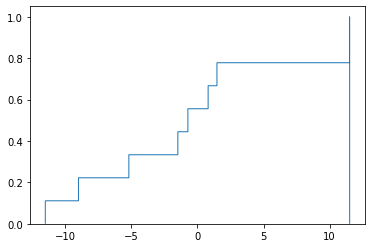

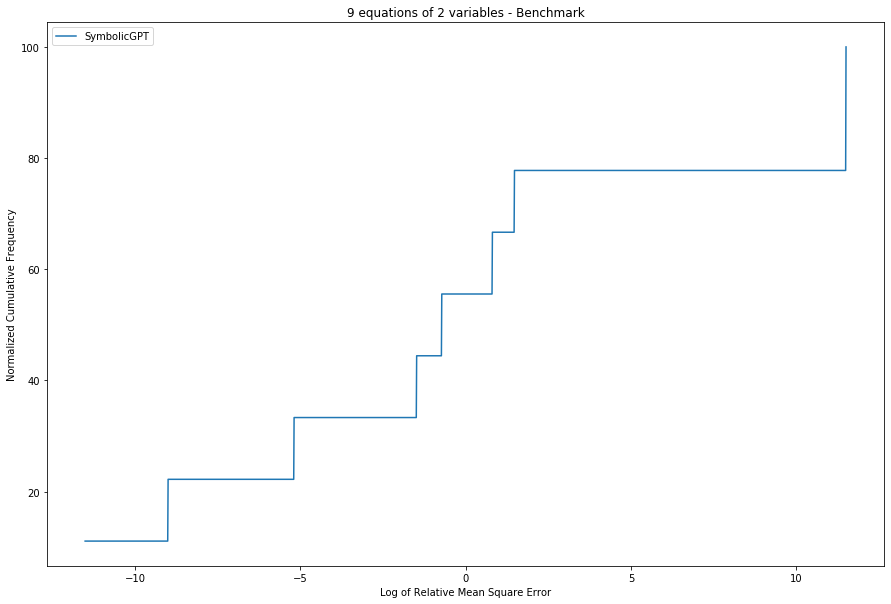

In [119]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables - Benchmark".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName.split('.txt')[0])
plt.savefig(name)

In [155]:
# benchmarks
import csv
benchmarkPath = './benchmark/dsr-benchmark-data/'
dataPoints = glob.glob(benchmarkPath+'*.csv')
NGUYEN2Eq = {
           '1':'x1**3+x1**2+x1',
           '2':'x1**4+x1**3+x1**2+x1',
           '3':'x1**5+x1**4+x1**3+x1**2+x1',
           '4':'x1**6+x1**5+x1**4+x1**3+x1**2+x1',
           '5':'sin(x1**2)*cos(x1)-1',
           '6':'sin(x1)+sin(x1+x1**2)',
           '7':'log(x1+1)+log(x1**2+1)',
           '8':'sqrt(x1)',
           '9':'sin(x1)+sin(x2**2)',
           '10':'2*sin(x1)*cos(x2)',
           '11':'x1**x2',
           '12':'x1**4-x1**3+x2**2/2-x2',}
for dataPoint in dataPoints: 
    key = dataPoint.split('\\')[-1].split('Nguyen-')[-1].split('_')[0]
    if not key in NGUYEN2Eq.keys():
        continue
    target = NGUYEN2Eq[key]
    with open(dataPoint, newline='\n') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        pointsList = []
        pointsListTest = []
        for i, c in enumerate(reader):
            p = ([eval(x) for x in c[:-1]],eval(c[-1]))
            if i < numPoints:
                pointsList.append(p)
            else:
                pointsListTest.append(p)
                
        #pointsList = [([eval(x) for x in p[:-1]],eval(p[-1])) for i,p in enumerate(reader) if i < numPoints]
        #pointsListTest = [([eval(x) for x in p[:-1]],eval(p[-1])) for i,p in enumerate(reader) if i >= numPoints]
        
        # initialized the input variable with start token <
        inputs = torch.tensor([[train_dataset.stoi['<']]]).to(trainer.device)
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(pointsList):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=train_dataset.threshold[1], 
                                 neginf=train_dataset.threshold[0])
            p[p>train_dataset.threshold[1]] = train_dataset.threshold[1] # clip the upper bound
            p[p<train_dataset.threshold[0]] = train_dataset.threshold[0] # clip the lower bound
            points[:,idx] = p
            
        points = points.unsqueeze(0).to(trainer.device)
        outputsHat = sample(model, inputs, blockSize, points=points,
                      temperature=1.0, sample=False, 
                      top_k=40)[0]
        
        # filter out predicted
        predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])
        predicted = predicted.strip(train_dataset.paddingToken).split('>')
        predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
        predicted = predicted.strip('<').strip(">")
        
        # extract points from the input sequence
        pointsTest = torch.zeros(numVars+numYs, numPoints).numpy()
        for idx, xy in enumerate(pointsListTest):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=train_dataset.threshold[1], 
                                 neginf=train_dataset.threshold[0])
            p[p>train_dataset.threshold[1]] = train_dataset.threshold[1] # clip the upper bound
            p[p<train_dataset.threshold[0]] = train_dataset.threshold[0] # clip the lower bound
            pointsTest[:,idx] = p
        
        Ys = [] 
        Yhats = []
        for xs in pointsTest[:-1,:].T:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 100 if np.isinf(YEval) else YEval
            except:
                YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 100 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 100
            Yhats.append(Yhat)
        err = relativeErr(Ys,Yhats)
        
        print('NGUYEN-{} --> Target:{}\nPredicted:{}\nErr:{}\n'.format(key, target, predicted, err))

NGUYEN-10 --> Target:2*sin(x1)*cos(x2)
Predicted:log(abs(exp(1.0*x1)))
Err:0.07436004532630844

NGUYEN-11 --> Target:x1**x2
Predicted:sqrt(abs(1.0*x1**2))
Err:0.04597928135266842

NGUYEN-12 --> Target:x1**4-x1**3+x2**2/2-x2
Predicted:log(abs(1.0*x1))
Err:2.662821440368008

NGUYEN-1 --> Target:x1**3+x1**2+x1
Predicted:2.0*x1
Err:0.08973579546591479

NGUYEN-2 --> Target:x1**4+x1**3+x1**2+x1
Predicted:2.0*x1
Err:0.18876219523142349

NGUYEN-3 --> Target:x1**5+x1**4+x1**3+x1**2+x1
Predicted:4.0*x1
Err:0.6610746693797507

NGUYEN-4 --> Target:x1**6+x1**5+x1**4+x1**3+x1**2+x1
Predicted:4.0*x1**2+sin(1.0*x1)
Err:0.06631700903386478

NGUYEN-5 --> Target:sin(x1**2)*cos(x1)-1
Predicted:log(abs(1.0*x1**2))
Err:3.592194233969905

NGUYEN-6 --> Target:sin(x1)+sin(x1+x1**2)
Predicted:1.0*x1+sin(sqrt(abs(1.0*x1)))
Err:0.5954981508716823

NGUYEN-7 --> Target:log(x1+1)+log(x1**2+1)
Predicted:1.0*x1*sqrt(abs(1.0*x1))*sin(1.0*x1)
Err:0.13763041363018041

NGUYEN-8 --> Target:sqrt(x1)
Predicted:sqrt(abs(1.0*x